# Running OBRWR on HPN Data

In [4]:
import pickle

import numpy as np
import networkx as nx
import pandas as pd
from obrwr import obrwr_new as ob

In [2]:
file_name_PPI = "phonemesPKN.tsv"
back_path = "../"
activ = 'HGF'
sensitive_proteins_file = "00_InputData/stimuli/top_tables_novoom/UACC812_HGF_toptable.tsv"

## Building the network from PHONEMeS 

In [3]:
df = pd.read_csv(back_path+'05_Output/phonemesPKN/UACC812_HGF_PKN.tsv',sep='\t')
l = []
for el in df['target']:
    if (('_' in el) and (not '__' in el)):
        l.append(el)
targetphos = [el.split('_')[0] for el in l]
tmp = pd.DataFrame({'source':l,'target':targetphos})
df = pd.concat([df,tmp])
df = df.drop('interaction',axis=1).drop_duplicates(ignore_index=True)
df

,source,target
0,CALM3,TRPC1
1,CAV1,TRPC1
2,DRD2,TRPC1
3,FKBP4,TRPC1
4,MARCKS,TRPC1
...,...,...
10718,EIF4EBP1_T37,EIF4EBP1
10719,EIF4EBP1_T46,EIF4EBP1
10720,EIF4EBP1_S65,EIF4EBP1
10721,RPS6KA1_T359,RPS6KA1


## Building PPI

In [4]:
nodes = set(df['source']).union(set(df['target'])) 
df_PPI = pd.read_csv('../00_InputData/PPI/human_binary_network_gene.txt',header=None,sep='\t')
mask = [el in nodes for el in df_PPI[0]] or [el in nodes for el in df_PPI[1]]
df_PPI = df_PPI[mask].drop_duplicates(ignore_index=True)
df_PPI.columns = ['source','target']

In [5]:
df_PPI

,source,target
0,TRAF1,ARID5A
1,TRAF1,ZFYVE26
2,TRAF1,KRT75
3,TRAF1,TRAF2
4,TRAF1,SDCBP2
...,...,...
23010,DRD1,HRH3
23011,DRD1,DNAJC14
23012,SOX4,RGSL1
23013,SOX4,NANOGNB


## Adding the phosphosites from the HPN-Dream data 

In [6]:
df_psite = pd.read_csv(back_path+sensitive_proteins_file,sep='\t')
df_psite = df_psite.drop_duplicates()
df_psite.head()

,logFC,AveExpr,t,P.Value,adj.P.Val,B,ID
0,0.163701,0.684030,6.688942,4.114353e-08,0.000003,8.464145,YBX1_S102
1,-1.099837,2.713830,-5.100142,7.740401e-06,0.000135,3.339287,AKT1_S473
2,-1.099837,2.713830,-5.100142,7.740401e-06,0.000135,3.339287,AKT2_S473
3,-1.099837,2.713830,-5.100142,7.740401e-06,0.000135,3.339287,AKT3_S473
4,-0.449835,2.380587,-4.834206,1.831424e-05,0.000214,2.502288,GSK3A_S9.1


In [7]:
psites = [(el,el.split('_')[0]) for el in list(df_psite['ID'])]
df_diff = pd.DataFrame(psites,columns=['source','target'])
df_diff

,source,target
0,YBX1_S102,YBX1
1,AKT1_S473,AKT1
2,AKT2_S473,AKT2
3,AKT3_S473,AKT3
4,GSK3A_S9.1,GSK3A
...,...,...
65,CDKN1B_T198,CDKN1B
66,RAF1_S338,RAF1
67,PRKCA_S657,PRKCA
68,PRKAA1_T172,PRKAA1


In [8]:
df_phon = pd.read_csv(back_path+"05_Output/"+file_name_PPI,sep='\t')
psites = list(df_psite['ID'])
mask = [(el in psites) for el in df_phon['target']]
df_phon = df_phon[mask].drop_duplicates(ignore_index=True)
df_phon

,source,interaction,target
0,SGK1,1,CDKN1B_T157
1,SGK1,1,CDKN1B_T198
2,SGK1,1,GSK3A_S21
3,SGK1,1,GSK3B_S21
4,SGK1,1,RICTOR_T1135
...,...,...,...
421,MAP3K2,1,MAPK3_Y204
422,MAP3K2,1,MAPK3_T202
423,MAP4K5,1,GSK3B_S9
424,IKBKG,1,RELA_S536


## Building the networkx graph object from the different DataFrames

In [9]:
G_phos = nx.from_pandas_edgelist(df,create_using=nx.DiGraph)
G_hpn_psites = nx.DiGraph(nx.from_pandas_edgelist(df_diff))
G_link = nx.from_pandas_edgelist(df_phon,create_using=nx.DiGraph)
G_PPI = nx.DiGraph(nx.from_pandas_edgelist(df_PPI))
len(G_PPI.edges)

46008

In [10]:
G = nx.compose(G_phos,G_PPI)
G = nx.compose(G,G_hpn_psites)
G = nx.compose(G,G_link)

In [11]:
len(G.edges)

55133

## Creating a mygraph object from the obrwr package

In [12]:
myGraph = ob.MyGraph(G,self_loop=True)
myGraph.set_sources([activ],1e6)

/opt/conda/lib/python3.10/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:318: SparseEfficiencyWarning: splu requires CSC matrix format
  warn('splu requires CSC matrix format', SparseEfficiencyWarning)
/opt/conda/lib/python3.10/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:215: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  warn('spsolve is more efficient when sparse b '


[4377]

## Selecting perturbed proteins

In [13]:
df_psite = df_psite[df_psite['adj.P.Val'] < 5e-2]
df_psite

,logFC,AveExpr,t,P.Value,adj.P.Val,B,ID
0,0.163701,0.684030,6.688942,4.114353e-08,0.000003,8.464145,YBX1_S102
1,-1.099837,2.713830,-5.100142,7.740401e-06,0.000135,3.339287,AKT1_S473
2,-1.099837,2.713830,-5.100142,7.740401e-06,0.000135,3.339287,AKT2_S473
3,-1.099837,2.713830,-5.100142,7.740401e-06,0.000135,3.339287,AKT3_S473
4,-0.449835,2.380587,-4.834206,1.831424e-05,0.000214,2.502288,GSK3A_S9.1
5,-0.449835,2.380587,-4.834206,1.831424e-05,0.000214,2.502288,GSK3B_S9.1
6,-0.170752,0.969020,-4.231228,1.238150e-04,0.001238,0.655375,NDRG1_T346
7,-0.773111,3.984373,-4.028278,2.315473e-04,0.001473,0.054505,GSK3A_S9
8,-0.773111,3.984373,-4.028278,2.315473e-04,0.001473,0.054505,GSK3A_S21
9,-0.773111,3.984373,-4.028278,2.315473e-04,0.001473,0.054505,GSK3B_S9


In [14]:
d = {}
for rec in df_psite.to_dict('records'):
    if not rec['ID'] in d.keys():
        var = 1 + np.abs(rec['logFC'])
        if not rec['ID'] in G.nodes():
            d[rec['ID'].split('_')[0]] = var
        else:
            d[rec['ID']] = var

## Running OBRWR

In [15]:
myGraph.set_targets(d,self_loops=False)
myGraph.map_elements_to_int()

YBX1_S102 1.163701067008731
AKT1_S473 2.0998366411749
AKT2_S473 2.0998366411749
AKT3_S473 2.0998366411749
GSK3A_S9.1 1.449834682718197
GSK3B_S9.1 1.449834682718197
NDRG1_T346 1.1707519586362
GSK3A_S9 1.773111230885211
GSK3A_S21 1.773111230885211
GSK3B_S9 1.773111230885211
GSK3B_S21 1.773111230885211
ERBB3_Y1298 1.323193688117517
STAT3_Y705 1.0360466700571842
RPS6KA1_T359 1.0425732786811235
RPS6KA1_S363 1.0425732786811235
YAP1_S127 1.311296506751471
AKT1_T308 1.503087490454875
AKT2_T308 1.503087490454875
AKT3_T308 1.503087490454875
RPS6_S240 2.4935178591638003
RPS6_S244 2.4935178591638003
SRC_Y527 2.30031379252941


/opt/conda/lib/python3.10/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:318: SparseEfficiencyWarning: splu requires CSC matrix format
  warn('splu requires CSC matrix format', SparseEfficiencyWarning)
/opt/conda/lib/python3.10/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:215: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  warn('spsolve is more efficient when sparse b '


In [17]:
beta_incr = 0.05
for beta in np.arange(beta_incr,1,beta_incr):
    myGraph.map_elements_to_int()
    eps_crit,_ = myGraph.find_eps_critic(beta,1e-1)
    _ = myGraph.optimize_biased_walk_normalized(eps_crit,beta)
    myGraph.add_meta_after_optim(eps_crit,beta,f'HGF{int(beta*100)}')
    myGraph.map_elements_to_names()
    nx.write_gml(myGraph.subGdirected_with_annot,back_path+'05_Output/meta_param_var/output_gml/'+activ+'_'+str(beta)+'.gml')

Model definition
Variable definition
Objective definition
Constr4 definition
sets defined
Constr5 definition
sets defined
Constr piisdist definition
Writing Model
Running HiGHS 1.6.0: Copyright (c) 2023 HiGHS under MIT licence terms
Presolving model
13563 rows, 60237 cols, 180711 nonzeros
7291 rows, 53965 cols, 176593 nonzeros
7286 rows, 51417 cols, 168923 nonzeros
Presolve : Reductions: rows 7286(-9637); columns 51417(-12180); elements 168923(-21868)
Solving the presolved LP
IPX model has 7286 rows, 51417 columns and 168923 nonzeros
Input
    Number of variables:                                51417
    Number of free variables:                           0
    Number of constraints:                              7286
    Number of equality constraints:                     7242
    Number of matrix entries:                           168923
    Matrix range:                                       [4e-06, 6e+01]
    RHS range:                                          [1e+00, 1e+06]
    Obj

/opt/conda/lib/python3.10/site-packages/obrwr/obrwr_new.py:376: RuntimeWarning: invalid value encountered in true_divide
  self.b = EX/np.array([piX[i[0]] for i in self.e_l])


Model definition
Variable definition
Objective definition
Constr4 definition
sets defined
Constr5 definition
sets defined
Constr piisdist definition
Writing Model
Running HiGHS 1.6.0: Copyright (c) 2023 HiGHS under MIT licence terms
Presolving model
13563 rows, 60237 cols, 180711 nonzeros
7280 rows, 53954 cols, 176671 nonzeros
7241 rows, 51372 cols, 168925 nonzeros
Presolve : Reductions: rows 7241(-9682); columns 51372(-12225); elements 168925(-21866)
Solving the presolved LP
IPX model has 7241 rows, 51372 columns and 168925 nonzeros
Input
    Number of variables:                                51372
    Number of free variables:                           0
    Number of constraints:                              7241
    Number of equality constraints:                     7197
    Number of matrix entries:                           168925
    Matrix range:                                       [3e-07, 1e+00]
    RHS range:                                          [1e+00, 1e+06]
    Obj

/opt/conda/lib/python3.10/site-packages/obrwr/obrwr_new.py:376: RuntimeWarning: divide by zero encountered in true_divide
  self.b = EX/np.array([piX[i[0]] for i in self.e_l])
/opt/conda/lib/python3.10/site-packages/obrwr/obrwr_new.py:380: RuntimeWarning: invalid value encountered in double_scalars
  self.b = [(self.b[i]/count[el[0]] if self.b[i] else 0) for i,el in enumerate(self.e_l)]


Model definition
Variable definition
Objective definition
Constr4 definition
sets defined
Constr5 definition
sets defined
Constr piisdist definition
Writing Model
Running HiGHS 1.6.0: Copyright (c) 2023 HiGHS under MIT licence terms
Presolving model
13563 rows, 60237 cols, 180711 nonzeros
7279 rows, 53953 cols, 176679 nonzeros
7242 rows, 51372 cols, 169064 nonzeros
Presolve : Reductions: rows 7242(-9681); columns 51372(-12225); elements 169064(-21727)
Solving the presolved LP
IPX model has 7242 rows, 51372 columns and 169064 nonzeros
Input
    Number of variables:                                51372
    Number of free variables:                           0
    Number of constraints:                              7242
    Number of equality constraints:                     7198
    Number of matrix entries:                           169064
    Matrix range:                                       [6e-08, 1e+00]
    RHS range:                                          [1e+00, 1e+06]
    Obj

/opt/conda/lib/python3.10/site-packages/obrwr/obrwr_new.py:402: RuntimeWarning: divide by zero encountered in log2
  tmp = {key:np.log2(val/self.stable[key]) for key,val in enumerate(self.pi)}


# Building paths

In [5]:
from heapq import *

def path_weight(G, path,weight,tot=1e4,beta=0.7):
    cost=1
    if not nx.is_path(G, path):
        raise nx.NetworkXNoPath("path does not exist")
    for node, nbr in nx.utils.pairwise(path):
        d = G.get_edge_data(node,nbr)
        cost *= (1-beta)*d[weight]
    return beta*tot*cost

def to_probas(distances):
    n1 = list(distances.keys())[0]
    tmp = {n2:{} for n2 in distances[n1].keys()}
    for node1 in distances.keys():
        for node2 in distances[node1].keys():
            tmp[node2][node1] = np.exp(-distances[node1][node2])
    return tmp

def maxprob_to_targets(node,targets_left,sp_distances,Ts):
    maxprob = 0
    for target in targets_left:
        d = sp_distances[node][target]
        if d > maxprob:
            maxprob = d
    return maxprob
    
def enumerate_path_heap(G,targets,experiment,source='SRC_HUMAN',beta=0.7,r=1e-1,Tot=1e4,verbose=False,mode='total'):
    weight_sp = lambda u,v,d: -np.log((1-beta)*d['weights'+experiment])
    Ts = {t:G.nodes[t]['Pi'+experiment] for t in targets}
    pathstotarget = {t:[[],0] for t in targets}
    G_rev = G.reverse()
    sp_distances = {}
    for t in targets :
        sp_distances[t] = dict(nx.single_source_dijkstra_path_length(G_rev,t,weight = weight_sp))
        
    sp_distances = to_probas(sp_distances)
    if verbose :
        print('Ts :',Ts)
    weight = lambda d: d['weights'+experiment]
    
    initial_item = [-beta*Tot,beta*Tot,[source]]
    h = []
    heappush(h,initial_item)
    
    targets_left = set(targets)
    while len(targets_left) and len(h):
        dist2target, path_prob, path = heappop(h)
        if path[-1] in targets_left:
            tar = path[-1]
            pathstotarget[tar][0].append(path)
            pathstotarget[tar][1] += path_prob
            tmp_b = False
            if mode == 'percent' and path_prob/Ts[tar] < r:
                targets_left.remove(tar)
                tmp_b = True
            elif mode == 'total' and pathstotarget[tar][1] > (1-r)*Ts[tar]:
                targets_left.remove(tar)
                tmp_b = True
            if tmp_b and verbose:
                print('Target found :',tar)
                print('Probas found :',{t:pathstotarget[t][1] for t in targets})
                print('targets_left :', targets_left)
        for neigh in nx.neighbors(OriginalG,path[-1]):
            wedge = (1-beta)*weight(OriginalG.edges[(path[-1],neigh)])
            maxp = maxprob_to_targets(neigh,targets_left,sp_distances,Ts)
            heappush(h,[-path_prob*wedge*maxp,path_prob*wedge,path+[neigh]])
    return pathstotarget

In [8]:
file_complete = "../05_Output/meta_param_var/HGF_0.55.gml"
experiment = 'HGF55'
OriginalG = nx.read_gml(file_complete)
targets_attr = nx.get_node_attributes(OriginalG,'Targets')
original_targets = [n for n in OriginalG.nodes() if targets_attr[n]]

Stot = np.sum(list(nx.get_node_attributes(OriginalG,'Pi'+experiment).values()))
if np.abs(Stot - 1e6) < 1e-3 :
    print(f'OK {experiment}')
else:
    print(f'NOK {experiment}')
    print(Stot)

OK HGF55


In [15]:
file_complete = "../05_Output/meta_param_var/HGF_0.9000000000000001.gml"
folder_exp = "../05_Output/meta_param_var"
OriginalG = nx.read_gml(file_complete)
beta_incr=0.05
rmin = 5e-2
r_incr = 1e-1
for i in range(0,9):
    r = rmin + i*r_incr
    for beta in np.arange((2*i+1)*beta_incr,1-beta_incr,beta_incr):
            experiment = f'HGF{int(np.round(beta*100))}'
            targets_attr = nx.get_node_attributes(OriginalG,'Targets')
            original_targets = [n for n in OriginalG.nodes() if targets_attr[n]]

            Stot = np.sum(list(nx.get_node_attributes(OriginalG,'Pi'+experiment).values()))
            if np.abs(Stot - 1e6) < 1e-3 :
                print(f'OK {experiment}')
            else:
                print(f'NOK {experiment}')
                continue

            pathstotarget = enumerate_path_heap(OriginalG,original_targets,experiment,source='HGF',beta=beta,Tot=Stot,r=1-r,mode='total',verbose = True)

            paths = []
            for target in original_targets:
                T = OriginalG.nodes[target]['Pi'+experiment]
                tpaths,s = pathstotarget[target]
                paths += tpaths
                print(f'Explained prob. of {target}: {s/T}')
                print(f'Number of paths : {len(tpaths)}')

            sources,targets = [],[]
            edges = []
            for path in paths:
                for s,t in zip(path[:-1],path[1:]):
                    sources.append(s)
                    targets.append(t)
                    edges.append((s,t))
            df = pd.DataFrame({'Sources':sources,'Targets':targets})
            df = df.drop_duplicates()
            df.to_csv(folder_exp+'/paths_'+experiment+f'_R{int(np.round(r*100))}'+'.tsv',sep='\t',index=False)
            FinG = OriginalG.edge_subgraph(edges).copy()
            nx.write_gml(FinG,folder_exp+'/output_gml/paths_'+experiment+f'_R{int(np.round(r*100))}'+'.gml')

OK HGF5
Ts : {'GSK3B_S9.1': 32.5210422147762, 'STAT3_Y705': 1495.313833541187, 'RPS6KA1_T359': 118.8078647330295, 'AKT2_T308': 16.577980612699, 'GSK3B_S9': 720.7246585361191, 'SRC_Y527': 63.1249163708919, 'GSK3A_S9.1': 45.621581414065, 'YAP1_S127': 296.6738531973901, 'YBX1_S102': 162.1812551025798, 'RPS6_S240': 422.5165173115839, 'ERBB3_Y1298': 90.1929724622148, 'AKT1_S473': 1634.702192248079, 'AKT1_T308': 930.0157303992177, 'RPS6_S244': 216.2078176570234, 'AKT2_S473': 23.1596971888161, 'GSK3A_S9': 55.7940428244988, 'GSK3B_S21': 106.2828073947341, 'RPS6KA1_S363': 146.6440020782884, 'AKT3_S473': 24.427945348199, 'NDRG1_T346': 103.2575077729628, 'GSK3A_S21': 473.4596851466587, 'AKT3_T308': 17.4858073958788}
Target found : AKT1_S473
Probas found : {'GSK3B_S9.1': 0, 'STAT3_Y705': 0, 'RPS6KA1_T359': 0, 'AKT2_T308': 0, 'GSK3B_S9': 0, 'SRC_Y527': 0, 'GSK3A_S9.1': 0, 'YAP1_S127': 0, 'YBX1_S102': 0, 'RPS6_S240': 0, 'ERBB3_Y1298': 0, 'AKT1_S473': 276.8381691203091, 'AKT1_T308': 0, 'RPS6_S244': 0

# To gr format

In [21]:
folder_input = "../05_Output/meta_param_var/output_gml"
folder_output = "../05_Output/meta_param_var/output_gr"
beta_incr=0.05
rmin = 5e-2
r_incr = 1e-1
for i in range(0,9):
    r = rmin + i*r_incr
    for beta in np.arange((2*i+1)*beta_incr,1-beta_incr,beta_incr):
        experiment = f'HGF{int(np.round(beta*100))}'
        filename = 'paths_'+experiment+f'_R{int(np.round(r*100))}'
        G = nx.read_gml(folder_input+'/'+filename+'.gml')
        G = G.to_undirected()
        G = nx.convert_node_labels_to_integers(G,first_label=1)
        with open(folder_output+'/'+filename+'.gr','w') as f:
            f.write(f'p tw {len(G.nodes)} {len(G.edges)}')
            for (i,j) in G.edges():
                f.write(f'\n{i} {j}')

# Inclusions

In [5]:
import plotly.graph_objects as go
import matplotlib.pyplot as plt

/tmp/ipykernel_316/2321428333.py:32: RuntimeWarning: divide by zero encountered in log
  im = ax.imshow(np.log(heatmap_vals)+3, cmap = 'cool' )
/tmp/ipykernel_316/2321428333.py:33: RuntimeWarning: divide by zero encountered in log
  colours = im.cmap(im.norm(np.log(heatmap_vals)+3))
/tmp/ipykernel_316/2321428333.py:34: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cbar = fig.colorbar(im)


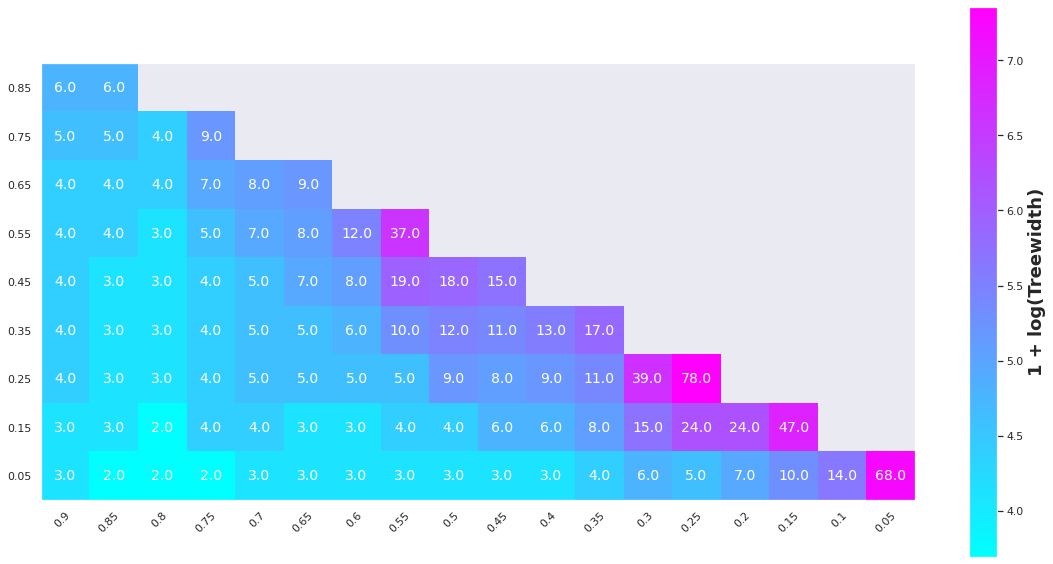

In [13]:
folder_input = "../05_Output/meta_param_var/output_td/"

beta_incr=0.05
rmin = 5e-2
r_incr = 1e-1
heatmap_vals = np.zeros((9,18))
label = [""]
R = []
Beta = []
def read_file(path):
    with open(path,'r') as f:
        for line in f.readlines():
            l = line.strip().split()
            if l[0] == 's':
                return int(l[3])
    return -1

for i in range(0,9):
    r = rmin + i*r_incr
    R.append(f'{r:.2}')
    for j,beta in enumerate(np.arange((2*i+1)*beta_incr,1-beta_incr,beta_incr)):
        if i == 0:
            Beta.append(f'{beta:.2}')
        experiment = f'HGF{int(np.round(beta*100))}'+f'_R{int(np.round(r*100))}'
        label.append(experiment)
        filename = 'paths_'+experiment+'.td'
        heatmap_vals[8-i,17-(2*i +j)] = read_file(folder_input + filename)

R.reverse()
Beta.reverse()
fig, ax = plt.subplots(figsize=(16,8))
im = ax.imshow(np.log(heatmap_vals)+3, cmap = 'cool' )
colours = im.cmap(im.norm(np.log(heatmap_vals)+3))
cbar = fig.colorbar(im) 
cbar.set_label('1 + log(Treewidth)',size=18,weight='bold')
ax.set_xticks(np.arange(len(Beta)), labels=Beta)
ax.set_yticks(np.arange(len(R)), labels=R)

plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

for i in range(len(R)):
    for j in range(len(Beta)):
        if heatmap_vals[i, j] != 0:
            text = ax.text(j, i, heatmap_vals[i, j],
                           ha="center", va="center", color="w", fontsize=14)
ax.grid(False)
fig.tight_layout()
plt.savefig("../05_Output/meta_param_var/figs/heatmap.png",dpi=600)

In [82]:
def toplotlyc(c):
    return f'rgba({c[0]*255},{c[1]*255},{c[2]*255},{c[3]})'

def plot_sankey_from_edge_sets(edge_set,label,colours):
    N = len(edge_set)
    M = np.zeros((N+1,N+1))
    for i in range(N):
        s = edge_set[i]
        for j in range(i+1,N):
            tmp = edge_set[j].intersection(s)
            M[i,j] = len(tmp)
            s = s - tmp
        M[i,N] = min(len(s),400)
    sources = []
    targets = []
    values = []
    colors = []
    for i in range(N):
        for j in range(i+1,N+1):
            if M[i,j] != 0:
                sources.append(i)
                targets.append(j)
                alpha = M[i,j]/len(edge_set[i])
                values.append(M[i,j])
                c = colours[8,i]
                if j == N:
                    colors.append('rgba(0,0,0,0)')
                else:
                    colors.append(f'rgba({c[0]*255},{c[1]*255},{c[2]*255},{alpha})')
    no_line = dict(color = "black", width = 0)
    fig = go.Figure(go.Sankey(
        arrangement = "snap",
        node = {
            "label": ["" for _ in range(N+1)],
            "x": [0]+[0.05*i for i in range(1,N)]+[0],
            "y": [-0.05]+[-0.05*i for i in range(1,N)]+[0],
            "color" : [toplotlyc(colours[8,i]) for i in range(N)]+['rgba(0,0,0,0)'],
            'pad':5},  # 10 Pixels
        link = {
            "source": sources,
            "target": targets,
            "value": values,
            "color": colors
        }))
    fig.update_layout(
        autosize=True,
        width=4800,
        height=2000,
    )
    return fig

In [72]:
folder_input = "../05_Output/meta_param_var/output_gml"
experiment = "HGF5"
rmin = 5e-2
r_incr = 1e-1
beta_incr=0.05
i = 0
r = rmin + i*r_incr
edge_set = []
label = [""]
for beta in np.arange((2*i+1)*beta_incr,1-beta_incr,beta_incr):
        experiment = f'HGF{int(np.round(beta*100))}'+f'_R{int(np.round(r*100))}'
        filename = 'paths_'+experiment
        print(filename)
        G = nx.read_gml(folder_input+'/'+filename+'.gml')
        edge_set.append(set(G.edges()))
        label.append(experiment)
edge_set.reverse()
label.reverse()

paths_HGF5_R5
paths_HGF10_R5
paths_HGF15_R5
paths_HGF20_R5
paths_HGF25_R5
paths_HGF30_R5
paths_HGF35_R5
paths_HGF40_R5
paths_HGF45_R5
paths_HGF50_R5
paths_HGF55_R5
paths_HGF60_R5
paths_HGF65_R5
paths_HGF70_R5
paths_HGF75_R5
paths_HGF80_R5
paths_HGF85_R5
paths_HGF90_R5


In [84]:
fig = plot_sankey_from_edge_sets(edge_set,label,colours)

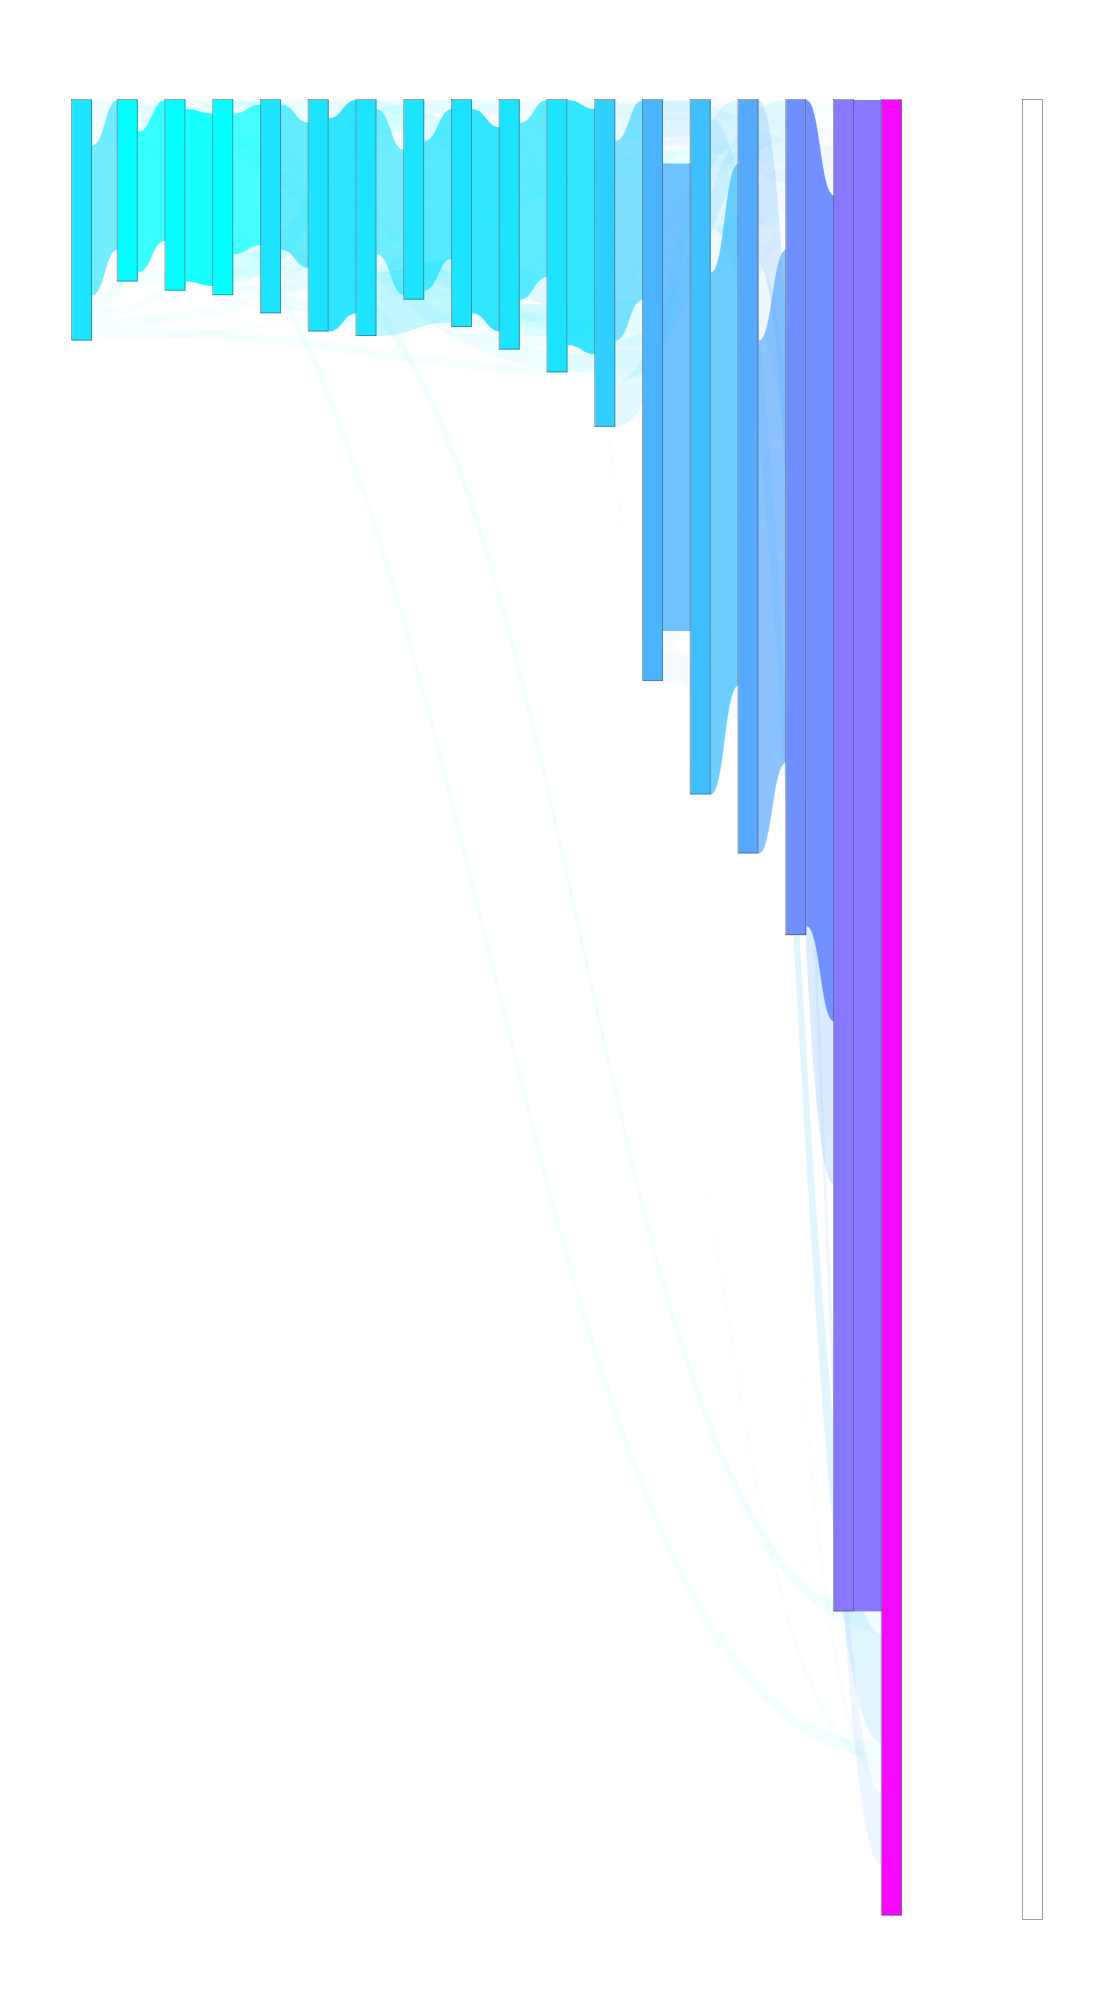

In [85]:
fig

In [89]:
colours[4,4]*255

array([ 64., 191., 255., 255.])